In [1]:
pip install torch>=1.13.0+cu116 torchvision>=0.13.0+cu116 torchaudio>=0.13.0 --extra-index-url https://download.pytorch.org/whl/cu116

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import os
import matplotlib.pyplot as plt
import random

In [4]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [5]:
dataset_path = r'C:\Users\vighn\Desktop\AI Project\Dataset 1'
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
class_names = dataset.classes
print(class_names)

['Buffalo', 'Elephant', 'Rhino', 'Zebra']


In [6]:
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size


In [7]:
train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

In [8]:
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [9]:
model = models.inception_v3(weights=None)

C:\Users\vighn\anaconda3\Lib\site-packages\torchvision\models\inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


In [10]:
model.fc = nn.Sequential(
    nn.Dropout(0.5),  
    nn.Linear(model.fc.in_features, 4)  
)

In [11]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [13]:
num_epochs = 15
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    model.train()

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad() 
     
        outputs = model(inputs)

        if isinstance(outputs, tuple):
            main_output, aux_output = outputs
            loss = (
                loss_function(main_output, labels)
                + 0.4 * loss_function(aux_output, labels)
            )  
        else:
            loss = loss_function(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(main_output, 1) if isinstance(outputs, tuple) else torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")




Epoch [1/15], Loss: 1.4012, Accuracy: 59.04%
Epoch [2/15], Loss: 0.9252, Accuracy: 72.54%
Epoch [3/15], Loss: 0.7512, Accuracy: 79.89%
Epoch [4/15], Loss: 0.6515, Accuracy: 81.86%
Epoch [5/15], Loss: 0.5749, Accuracy: 84.96%
Epoch [6/15], Loss: 0.4698, Accuracy: 87.29%
Epoch [7/15], Loss: 0.4524, Accuracy: 87.36%
Epoch [8/15], Loss: 0.4134, Accuracy: 89.00%
Epoch [9/15], Loss: 0.3598, Accuracy: 90.36%
Epoch [10/15], Loss: 0.3217, Accuracy: 91.36%
Epoch [11/15], Loss: 0.2370, Accuracy: 94.07%
Epoch [12/15], Loss: 0.2819, Accuracy: 92.50%
Epoch [13/15], Loss: 0.2603, Accuracy: 93.29%
Epoch [14/15], Loss: 0.2702, Accuracy: 92.93%
Epoch [15/15], Loss: 0.1958, Accuracy: 94.93%


In [14]:

torch.save(model, "final_model_inceptionv3(Dataset1).pth")

In [15]:

model.eval() 
val_loss = 0.0
val_correct = 0
val_total = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        
      
        if isinstance(outputs, tuple):
            outputs = outputs[0]

        loss = loss_function(outputs, labels)
        val_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        val_total += labels.size(0)
        val_correct += (predicted == labels).sum().item()

In [16]:
val_loss /= len(val_loader)
val_accuracy = 100 * val_correct / val_total
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

Validation Loss: 0.4158, Validation Accuracy: 88.00%


In [17]:

model.eval()  
test_loss = 0.0
test_correct = 0
test_total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        
        
        if isinstance(outputs, tuple):
            outputs = outputs[0]

        loss = loss_function(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

In [18]:
test_loss /= len(test_loader)
test_accuracy = 100 * test_correct / test_total
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")



Test Loss: 0.3539, Test Accuracy: 89.00%


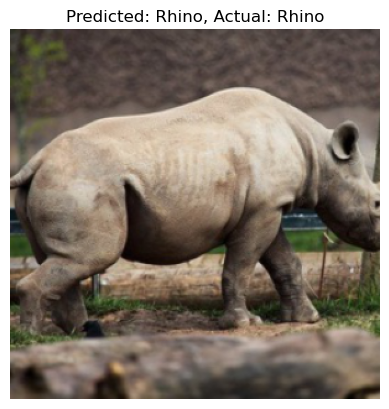

In [19]:
def show_random_test_prediction(model, test_data, class_names):
    model.eval()
    random_idx = random.randint(0, len(test_data) - 1)
    image, true_label = test_data[random_idx]
    image_tensor = image.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image_tensor)
        _, predicted_label = torch.max(output, 1)

    image_np = image.cpu().numpy().transpose((1, 2, 0))
    image_np = np.clip(image_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]), 0, 1)

    plt.imshow(image_np)
    plt.title(f"Predicted: {class_names[predicted_label.item()]}, Actual: {class_names[true_label]}")
    plt.axis("off")
    plt.show()

show_random_test_prediction(model, test_data, class_names)

In [20]:
val_loss = 0.0
val_correct = 0
val_total = 0
all_val_labels = []
all_val_preds = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        
        if isinstance(outputs, tuple):
            outputs = outputs[0]

        loss = nn.CrossEntropyLoss()(outputs, labels)
        val_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        val_total += labels.size(0)
        val_correct += (predicted == labels).sum().item()

        all_val_labels.extend(labels.cpu().numpy())
        all_val_preds.extend(predicted.cpu().numpy())

val_loss /= len(val_loader)
val_accuracy = 100 * val_correct / val_total
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

precision, recall, f1, _ = precision_recall_fscore_support(all_val_labels, all_val_preds, average='weighted')

print(f"Validation Precision: {precision:.4f}")
print(f"Validation Recall: {recall:.4f}")
print(f"Validation F1-Score: {f1:.4f}")


test_loss = 0.0
test_correct = 0
test_total = 0
all_test_labels = []
all_test_preds = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        
        if isinstance(outputs, tuple):
            outputs = outputs[0]

        loss = nn.CrossEntropyLoss()(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

        all_test_labels.extend(labels.cpu().numpy())
        all_test_preds.extend(predicted.cpu().numpy())

test_loss /= len(test_loader)
test_accuracy = 100 * test_correct / test_total
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

precision, recall, f1, _ = precision_recall_fscore_support(all_test_labels, all_test_preds, average='weighted')

print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1-Score: {f1:.4f}")

Validation Loss: 0.3794, Validation Accuracy: 89.00%
Validation Precision: 0.8967
Validation Recall: 0.8900
Validation F1-Score: 0.8893
Test Loss: 0.3486, Test Accuracy: 89.00%
Test Precision: 0.8967
Test Recall: 0.8900
Test F1-Score: 0.8894


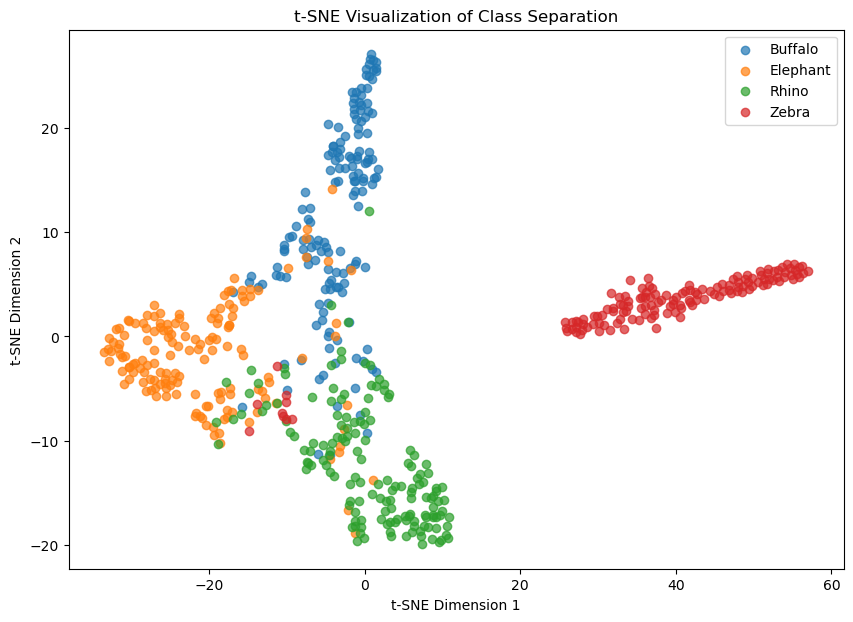

In [21]:
from sklearn.manifold import TSNE
import cv2


def extract_features_for_tsne(model, data_loader, device):
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for inputs, lbls in data_loader:
            inputs = inputs.to(device)
            lbls = lbls.to(device)
            
            features_batch = model(inputs)
            features.append(features_batch.cpu().numpy())
            labels.append(lbls.cpu().numpy())

    features = np.concatenate(features)
    labels = np.concatenate(labels)
    return features, labels

def visualize_tsne(features, labels, class_names):
    tsne = TSNE(n_components=2, random_state=42)
    tsne_features = tsne.fit_transform(features)

    plt.figure(figsize=(10, 7))
    for i, class_name in enumerate(class_names):
        idx = labels == i
        plt.scatter(tsne_features[idx, 0], tsne_features[idx, 1], label=class_name, alpha=0.7)
    plt.legend()
    plt.title("t-SNE Visualization of Class Separation")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.show()

features, labels = extract_features_for_tsne(model, val_loader, device)
visualize_tsne(features, labels, class_names)

